In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [15]:
#import the data
df = pd.read_csv(r'pump_model_data.csv')

In [16]:
df.columns

Index(['funder', 'installer', 'scheme_management', 'extraction_type_group',
       'quality_group', 'source_type', 'quantity', 'payment', 'basin',
       'waterpoint_type', 'age_at_record', 'id', 'status_group',
       'public_meeting', 'permit'],
      dtype='object')

In [17]:
#create dummies
dum_df = pd.get_dummies(df, columns=['funder', 'installer', 'scheme_management', 'extraction_type_group',
                                     'quality_group', 'source_type', 'quantity', 'payment', 'basin',
                                     'waterpoint_type', 'public_meeting', 'permit'] )

In [31]:
dum_df['status_group']= df.status_group

#reorder columns for ease of use
column_to_reorder = dum_df.pop('status_group')
dum_df.insert(0, 'status_group', column_to_reorder)
column_to_reorder_two = dum_df.pop('id')
#dum_df.insert(0, 'id', column_to_reorder_two)

print(dum_df.columns)
feature_names = list(dum_df.columns)

Index(['status_group', 'age_at_record', 'funder_Danida',
       'funder_Government Of Tanzania', 'funder_Hesawa', 'funder_Kkkt',
       'funder_Other', 'funder_Rwssp', 'funder_Unicef', 'funder_World Bank',
       'funder_World Vision', 'installer_Commu', 'installer_DANIDA',
       'installer_DWE', 'installer_Government', 'installer_Hesawa',
       'installer_KKKT', 'installer_Other', 'installer_RWE',
       'scheme_management_Company', 'scheme_management_Other',
       'scheme_management_Parastatal', 'scheme_management_Private operator',
       'scheme_management_VWC', 'scheme_management_WUA',
       'scheme_management_WUG', 'scheme_management_Water Board',
       'scheme_management_Water authority', 'extraction_type_group_afridev',
       'extraction_type_group_gravity', 'extraction_type_group_india mark ii',
       'extraction_type_group_india mark iii', 'extraction_type_group_mono',
       'extraction_type_group_nira/tanira', 'extraction_type_group_other',
       'extraction_type_gr

In [32]:
#convert labels to category codes
dum_df.status_group = dum_df['status_group'].astype('category').cat.codes
print(dum_df.status_group)

0        0
1        0
2        0
3        2
4        0
        ..
59395    0
59396    0
59397    0
59398    0
59399    0
Name: status_group, Length: 59400, dtype: int8


In [33]:
#convert labels column to an array
labels = dum_df['status_group']
labels_array = labels.squeeze().ravel()
print(labels_array)

#create dictionary for labels
dict_cats = {0: 'functional', 1 : 'functional needs repair', 2 : 'non functional'}

[0 0 0 ... 0 0 0]


In [34]:
#defining data
X_data = dum_df.iloc[:, 2:]
y_data = dum_df.iloc[:, 0:1]

#creating learning and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#convert the y data into an array
y_train = y_train.to_numpy().ravel()

(47520, 86)
(47520, 1)
(11880, 86)
(11880, 1)


In [35]:
#Initial random forest
forest_model = RandomForestClassifier(n_estimators=1000)
forest_model.fit(X_train, y_train)
print(forest_model.score(X_test, y_test))

0.7784511784511785


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50],
    'max_features': ['sqrt'],
    'max_depth' :[20],
    'min_samples_split' :[2,4,6],
    'min_samples_leaf' : list(range(3,5))}

In [ ]:
CV_rfc = GridSearchCV(estimator=forest_model, param_grid=param_grid)
CV_rfc.fit(X_train, y_train)

In [ ]:
print(CV_rfc.best_params_)

In [36]:
best_forest_model = RandomForestClassifier(n_estimators = 1000, max_features='sqrt', max_depth=20, min_samples_split=4, random_state=12)#,  min_samples_leaf=8)
best_forest_model.fit(X_train, y_train)
print(best_forest_model.score(X_test, y_test))

0.7828282828282829


Intepreting the results


In [37]:
#import libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

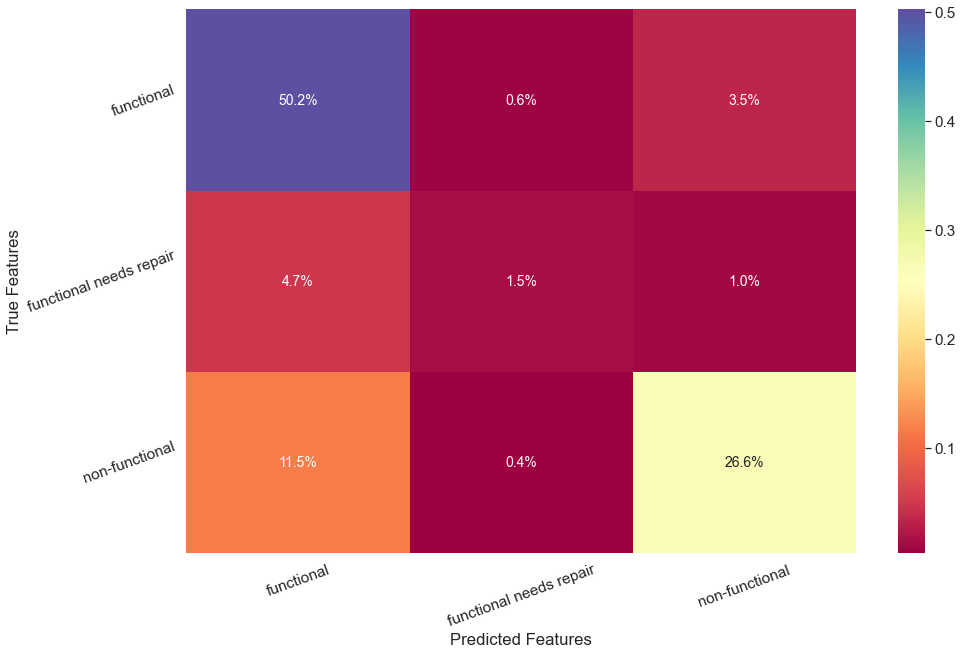

In [38]:
#confusion matrix
conf_mat = confusion_matrix(y_test, best_forest_model.predict(X_test))
fig, ax = plt.subplots(figsize=(15,10))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt = '.1%', cmap = 'Spectral', annot_kws={"size": 14})#xticklabels=dicts_cats, yticklabels=dicts_cats)
plt.xlabel('Predicted Features')
plt.ylabel('True Features')
ax.xaxis.set_ticklabels(['functional', 'functional needs repair', 'non-functional'], rotation=20)
ax.yaxis.set_ticklabels(['functional', 'functional needs repair', 'non-functional'], rotation=20 )
plt.savefig('confmat.jpg', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [39]:
#classfication report
prediction=best_forest_model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      6457
           1       0.59      0.20      0.30       851
           2       0.85      0.69      0.76      4572

    accuracy                           0.78     11880
   macro avg       0.74      0.61      0.63     11880
weighted avg       0.78      0.78      0.77     11880



In [40]:
#find most important features the model used to classification

df_importance = pd.DataFrame(columns=['features', 'importance'])
def select_best_tree_features(df,target_variable):

    y = df[target_variable]
    X = df.drop([target_variable], axis=1)
    model = RandomForestClassifier(n_estimators = 1000, max_features='sqrt', max_depth=20, min_samples_split=4, random_state=12)
    model.fit(X, y)
    df_importance['features'] = model.feature_importances_
    df_importance['importance'] = X.columns


    return df_importance

In [41]:
select_best_tree_features(dum_df, 'status_group')

,features,importance
0,0.115621,age_at_record
1,0.003988,funder_Danida
2,0.013503,funder_Government Of Tanzania
3,0.003426,funder_Hesawa
4,0.001371,funder_Kkkt
...,...,...
82,0.010769,public_meeting_True
83,0.005127,public_meeting_Unknown
84,0.012857,permit_False
85,0.013319,permit_True


In [42]:
df_importance['splits'] = df_importance.importance.str.split('_', expand=True)[0]


In [43]:
print(df_importance)

    features                     importance  splits
0   0.115621                  age_at_record     age
1   0.003988                  funder_Danida  funder
2   0.013503  funder_Government Of Tanzania  funder
3   0.003426                  funder_Hesawa  funder
4   0.001371                    funder_Kkkt  funder
..       ...                            ...     ...
82  0.010769            public_meeting_True  public
83  0.005127         public_meeting_Unknown  public
84  0.012857                   permit_False  permit
85  0.013319                    permit_True  permit
86  0.005708                 permit_Unknown  permit

[87 rows x 3 columns]


In [46]:
grouped_df = df_importance.groupby('splits').agg(aggregates=('features', 'sum'))


In [47]:
calculated_list = grouped_df.aggregates.to_list()
features_list =['Age of pump', 'Basin', 'Extraction Method', 'Funder', 'Installer', 'Payment method', 'Permit', 'Public meeting', 'Quality', 'Quantity', 'Scheme management', 'Source', 'Waterpoint type']

In [57]:
dict = {'Features' : features_list, 'Relative Importance' : calculated_list}
dfgraph = pd.DataFrame(dict)

             Features  Relative Importance
0         Age of pump             0.115621
1               Basin             0.079829
2   Extraction Method             0.102851
3              Funder             0.047755
4           Installer             0.045445
5      Payment method             0.075514
6              Permit             0.031884
7      Public meeting             0.024909
8             Quality             0.031537
9            Quantity             0.221812
10  Scheme management             0.056772
11             Source             0.054813
12    Waterpoint type             0.111257


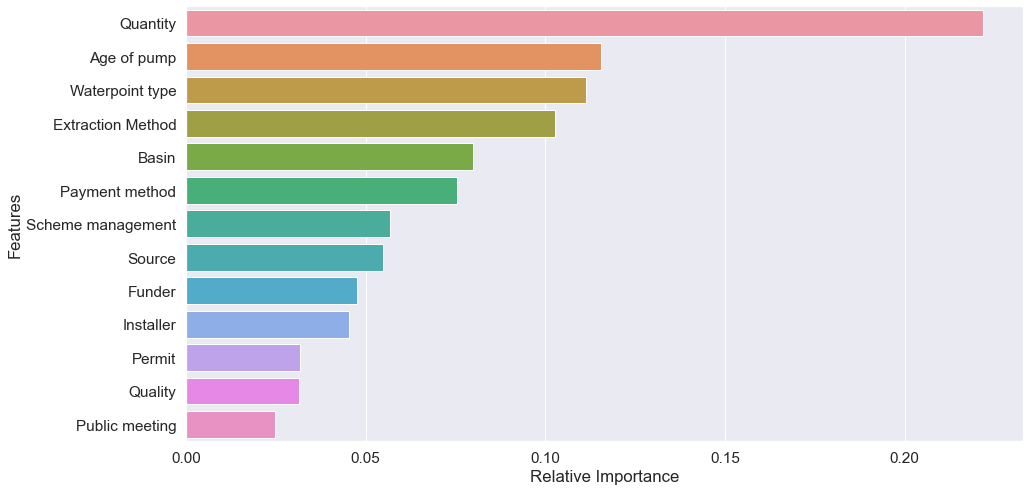

In [62]:
print(dfgraph)
plt.subplots(figsize=(15,8))
sns.barplot(x='Relative Importance', y='Features', data=dfgraph, order=dfgraph.sort_values('Relative Importance', ascending=False).Features )
plt.savefig('sns.jpg', bbox_inches="tight", pad_inches=0.1)

In [ ]:
#submission to DrivenData

In [69]:
#preparing data in correct format so submission
sub_df = pd.read_csv(r'test_pump_model_data.csv')
sub_dum_df = pd.get_dummies(sub_df, columns=['funder', 'installer', 'scheme_management', 'extraction_type_group',
                                               'quality_group', 'source_type', 'quantity', 'payment', 'basin',
                                               'waterpoint_type', 'public_meeting', 'permit'])
print(sub_dum_df.columns)
print(len(sub_dum_df))

Index(['age_at_record', 'id', 'funder_Danida', 'funder_Government Of Tanzania',
       'funder_Hesawa', 'funder_Kkkt', 'funder_Other', 'funder_Rwssp',
       'funder_Unicef', 'funder_World Bank', 'funder_World Vision',
       'installer_Commu', 'installer_DANIDA', 'installer_DWE',
       'installer_Government', 'installer_Hesawa', 'installer_KKKT',
       'installer_Other', 'installer_RWE', 'scheme_management_Company',
       'scheme_management_Other', 'scheme_management_Parastatal',
       'scheme_management_Private operator', 'scheme_management_VWC',
       'scheme_management_WUA', 'scheme_management_WUG',
       'scheme_management_Water Board', 'scheme_management_Water authority',
       'extraction_type_group_afridev', 'extraction_type_group_gravity',
       'extraction_type_group_india mark ii',
       'extraction_type_group_india mark iii', 'extraction_type_group_mono',
       'extraction_type_group_nira/tanira', 'extraction_type_group_other',
       'extraction_type_group_other 

In [75]:
sub_dum_df['status_group'] = ''
col1 = sub_dum_df.pop('status_group')
sub_dum_df.insert(0, 'status_group', col1)
#col_to_reorder = sub_dum_df.pop('id')
#sub_dum_df.insert(0, 'id', col_to_reorder)
print(sub_dum_df.columns)

sub_dum_df.to_csv(r'test_data_for_ML_with_dummies.csv')
test_X_data = sub_dum_df.iloc[:, 2:]

predictions = best_forest_model.predict(test_X_data)
print(predictions)

Index(['status_group', 'age_at_record', 'funder_Danida',
       'funder_Government Of Tanzania', 'funder_Hesawa', 'funder_Kkkt',
       'funder_Other', 'funder_Rwssp', 'funder_Unicef', 'funder_World Bank',
       'funder_World Vision', 'installer_Commu', 'installer_DANIDA',
       'installer_DWE', 'installer_Government', 'installer_Hesawa',
       'installer_KKKT', 'installer_Other', 'installer_RWE',
       'scheme_management_Company', 'scheme_management_Other',
       'scheme_management_Parastatal', 'scheme_management_Private operator',
       'scheme_management_VWC', 'scheme_management_WUA',
       'scheme_management_WUG', 'scheme_management_Water Board',
       'scheme_management_Water authority', 'extraction_type_group_afridev',
       'extraction_type_group_gravity', 'extraction_type_group_india mark ii',
       'extraction_type_group_india mark iii', 'extraction_type_group_mono',
       'extraction_type_group_nira/tanira', 'extraction_type_group_other',
       'extraction_type_gr

In [76]:

sub_dum_df.status_group = predictions
sub_dum_df['id'] = sub_df['id']
print(sub_dum_df.status_group)
sub = pd.read_csv(r'SubmissionFormat.csv')
result_df = sub_dum_df[['id', 'status_group']].copy()
print(result_df)

result_df.status_group = result_df.status_group.replace(dict_cats)
print(result_df)

#creating .csv for submission
result_df.to_csv(r'waterpump_submission_file.csv', index=False)

0        2
1        0
2        0
3        2
4        0
        ..
14845    2
14846    0
14847    0
14848    0
14849    2
Name: status_group, Length: 14850, dtype: int8
          id  status_group
0      50785             2
1      51630             0
2      17168             0
3      45559             2
4      49871             0
...      ...           ...
14845  39307             2
14846  18990             0
14847  28749             0
14848  33492             0
14849  68707             2

[14850 rows x 2 columns]
          id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]
